### Test pyro model with simulations

In [1]:
# TO REMOVE when notebook is stable

%load_ext autoreload
%autoreload 2

In [2]:
import pyro.distributions as dist
from pyro.distributions.torch_distribution import TorchDistribution
from tissue_purifier.genex.pyro_model_from_scratch import *
from tissue_purifier.genex.gene_utils import *

import numpy
import numpy as np
import torch
import seaborn
import tarfile
import os
import matplotlib
import matplotlib.pyplot as plt
from anndata import read_h5ad
import scanpy as sc
import pandas as pd

from torch.distributions.poisson import Poisson 


/home/jupyter/.local/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# rng = torch.Generator()
# seed = 142
# rng.manual_seed(seed)
# torch.randn((5,2), generator=rng)
# x = torch.random.get_rng_state()

In [4]:
# torch.randn((5,2), generator=rng)
# y = torch.random.get_rng_state()
# print(sum(x != y))

In [5]:
## set parameters for simulation

k = 5
n = 1000 * k
g = 10
nUmis = 10000
l = k # k #same b/c ncv

use_covariates_generate = True

In [6]:
## simulate fake counts

beta0_k1g = dist.Normal(-2, 1).sample((k,g))[:, None, :]

## normalize beta0s so they add up to 1 for each cell-type across all genes **?
## logsumexp to renormalize
beta0_k1g_norm = beta0_k1g - torch.logsumexp(beta0_k1g, dim=-1, keepdim=True)

total_umi_n1 = torch.tensor(nUmis).expand((n,1)).float()
total_umi_n11 = total_umi_n1[..., None]


# sample fake ncv vectors
prob = np.array([0.75])
ncv_n1l = dist.Dirichlet(torch.tensor(np.repeat(prob,[l]))).sample((n,1))
#ncv_n1l = torch.ones((n,1,l))

#print(ncv_n1l)
ncv_nl = torch.squeeze(ncv_n1l, 1)
ncv_nl1 = ncv_nl.unsqueeze(dim=-1)

## sample fake covariates
beta_klg = dist.Normal(0,1).sample((k,l,g))

## mean centering beta ##
#mean = torch.mean(beta_klg, dim=-2)
#mean = einops.repeat(mean, 'k g -> k l g', l=l)
#beta_klg = beta_klg - mean

#beta_klg = 2*torch.ones((k,l,g))
#beta_klg = beta_klg - torch.mean(beta_klg, dim=-2)
## add in sparsity + regularization later


cell_ids_n = (torch.rand((n))*k).int().long() ##randint instead
#beta0_n1g = beta0_k1g_norm[cell_ids_n]
beta0_n1g = beta0_k1g[cell_ids_n]
beta_nlg = beta_klg[cell_ids_n]

#print(beta_klg)
#print(torch.sum(ncv_nl1 * beta_nlg, dim=-2, keepdim=True))

if use_covariates_generate:
    log_mu_n1g = beta0_n1g + torch.sum(ncv_nl1 * beta_nlg, dim=-2, keepdim=True)
    #log_mu_n1g = torch.sum(ncv_nl1 * beta_nlg, dim=-2, keepdim=True)
else:
    log_mu_n1g = beta0_n1g

log_mu_n1g_norm = log_mu_n1g - torch.logsumexp(log_mu_n1g, dim=-1, keepdim=True) ## normalize across genes so that sum of umis is roughly correct
#log_mu_n1g_norm = log_mu_n1g
sim_counts_n1g = Poisson(rate=total_umi_n11*log_mu_n1g_norm.exp()).sample()



In [7]:
print(sim_counts_n1g.shape)
print(torch.mean(sim_counts_n1g.sum(dim=-1)))
print(beta0_k1g.shape)
print(beta0_n1g.shape)

torch.Size([5000, 1, 10])
tensor(10003.5168, dtype=torch.float64)
torch.Size([5, 1, 10])
torch.Size([5000, 1, 10])


### Fit model

In [8]:
use_covariates_model = True

In [9]:
## look for indexing bugs 

## Create GeneDataset

import anndata
from scipy import sparse

    
counts_ng = np.float32(sim_counts_n1g.squeeze()) ## assume n and g aren't 1
sim_anndata = anndata.AnnData(X=sparse.csr_matrix(counts_ng))
sim_anndata.obs['cell_type'] = cell_ids_n.numpy()
sim_anndata.obsm['ncv'] = np.array(ncv_nl)

## Run GLM

gene_dataset = make_gene_dataset_from_anndata(
        anndata=sim_anndata,
        cell_type_key='cell_type',
        covariate_key = 'ncv',
        preprocess_strategy='raw',
        apply_pca=False)


In [10]:
assert(np.all(np.array(gene_dataset.cell_type_ids) == cell_ids_n.numpy()))

[iter 0]  loss: 285774944.0000
[iter 500]  loss: 7968202.5000
[iter 1000]  loss: 1902193.6250
[iter 1500]  loss: 920842.5000
[iter 2000]  loss: 583426.5000
[iter 2500]  loss: 436138.0938
[iter 3000]  loss: 338997.0938
[iter 3500]  loss: 284269.4688
[iter 4000]  loss: 253928.8594
[iter 4500]  loss: 238182.4219
[iter 5000]  loss: 228121.2500
Training completed in 21.03100323677063 seconds


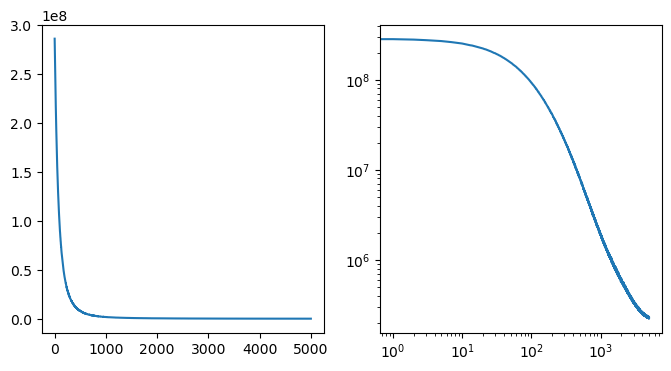

In [11]:
train_dataset, test_dataset, val_dataset = next(iter(train_test_val_split(gene_dataset, random_state=0, train_size=0.8,test_size=0.1,val_size=0.1)))

pyro.clear_param_store()
torch.cuda.empty_cache()
gr = GeneRegression()
gr.configure_optimizer(optimizer_type='adam', lr=5e-3)
beta0_k1g_store, beta_klg_store = gr.train(
    dataset=train_dataset,
    n_steps=5000,
    use_covariates = use_covariates_model,
    print_frequency=500,
    subsample_size_cells=1000)

fig, axes = plt.subplots(ncols=2, figsize=(8,4))
gr.show_loss(ax=axes[0])
gr.show_loss(ax=axes[1], logy=True, logx=True)

In [12]:
import pyro.poutine as poutine

trace = poutine.trace(gr._model).get_trace(n_cells= n,
           l_cov= l,
           g_genes= g,
           k_cell_types= k,
           use_covariates= use_covariates_model,
           counts_ng= gene_dataset.counts,
           total_umi_n= gene_dataset.counts.sum(dim=-1),
           covariates_nl= gene_dataset.covariates,
           cell_type_ids_n= gene_dataset.cell_type_ids,
           subsample_size_cells=None)
trace.compute_log_prob()  # optional, but allows printing of log_prob shapes
print(trace.format_shapes())

Trace Shapes:             
 Param Sites:             
        beta0 5    1 10   
         beta 5    5 10   
Sample Sites:             
   cells dist         |   
        value   5000  |   
     log_prob         |   
  counts dist   5000  | 10
        value   5000  | 10
     log_prob   5000  |   


### Evaluate model fit

In [13]:
## Get fit parameters
pred_beta0_k1g = pyro.get_param_store().get_param("beta0").float().cpu()

tensor(-3.0523)


Text(0.5, 1.0, 'beta0')

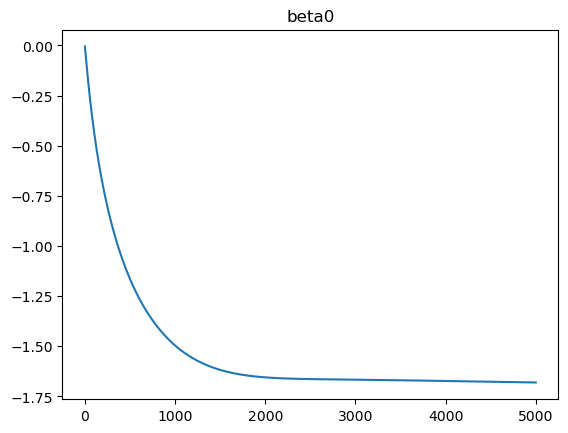

In [13]:
print(beta0_k1g_norm[1, 0, 0])

beta0_inspect = []
for beta0_k1g_temp in beta0_k1g_store:
    beta0_inspect.append(beta0_k1g_temp[1, 0, 0].detach().cpu().numpy())
    
    
plt.plot(beta0_inspect)
plt.title('beta0')

In [14]:
## beta 0 correlation
print("beta0 correlation:")
print(np.corrcoef(beta0_k1g_norm.detach().numpy().flatten(), pred_beta0_k1g.detach().numpy().flatten())[0,1])

beta0 correlation:
0.8859353312815986


In [15]:
print(pred_beta0_k1g)

tensor([[[-1.2437, -1.0949, -0.6025, -2.4258, -0.9915, -2.4133, -1.3133,
          -1.5191, -1.7649, -0.7993]],

        [[-2.4342, -2.2944, -0.5681, -1.5681, -1.7029, -1.3084, -0.4925,
          -2.0510, -2.4091, -1.0885]],

        [[-1.1998, -1.8641, -1.1285, -2.1606, -2.3480, -1.9082, -0.7781,
          -0.7309, -0.6336, -2.2214]],

        [[-0.3740, -1.5428, -2.5685, -2.0351, -1.7946, -2.8957, -1.2483,
          -1.4078, -0.7200, -1.5119]],

        [[-1.0248, -1.8245, -1.0538, -2.2722, -2.4424, -2.2108, -0.6349,
          -0.8173, -0.7827, -2.3811]]], grad_fn=<ToCopyBackward0>)


In [16]:
print(beta0_k1g_norm)

tensor([[[-2.4045, -3.9520, -2.3301, -4.4651, -3.9105, -3.4263, -0.9438,
          -2.1679, -1.5256, -4.8166]],

        [[-1.3831, -2.4276, -2.0072, -3.2158, -2.8932, -3.3348, -2.5924,
          -2.5675, -2.3996, -1.8765]],

        [[-2.7716, -1.4808, -1.2485, -4.8519, -2.5510, -5.0889, -3.0556,
          -2.8017, -3.5058, -1.6438]],

        [[-1.4801, -3.1765, -3.6280, -3.0854, -2.6246, -5.3314, -1.6458,
          -2.8143, -1.2621, -3.0964]],

        [[-3.0026, -4.3902, -1.6672, -2.4239, -3.3363, -2.4596, -1.0767,
          -3.1972, -3.8900, -1.9839]]])


In [17]:
print(beta0_k1g_norm.exp())

tensor([[[0.0903, 0.0192, 0.0973, 0.0115, 0.0200, 0.0325, 0.3891, 0.1144,
          0.2175, 0.0081]],

        [[0.2508, 0.0883, 0.1344, 0.0401, 0.0554, 0.0356, 0.0748, 0.0767,
          0.0908, 0.1531]],

        [[0.0626, 0.2275, 0.2869, 0.0078, 0.0780, 0.0062, 0.0471, 0.0607,
          0.0300, 0.1933]],

        [[0.2276, 0.0417, 0.0266, 0.0457, 0.0725, 0.0048, 0.1928, 0.0599,
          0.2831, 0.0452]],

        [[0.0497, 0.0124, 0.1888, 0.0886, 0.0356, 0.0855, 0.3407, 0.0409,
          0.0204, 0.1375]]])


In [18]:
gene_dataset.counts[gene_dataset.cell_type_ids == 0].sum(dim=0)/gene_dataset.counts[gene_dataset.cell_type_ids == 0].sum(dim=0).sum()

tensor([0.0461, 0.3630, 0.5909])

In [19]:
gene_dataset.counts[gene_dataset.cell_type_ids == 1].sum(dim=0)/gene_dataset.counts[gene_dataset.cell_type_ids == 1].sum(dim=0).sum()

tensor([0.2000, 0.0693, 0.7307])

Text(0, 0.5, 'predicted parameter value')

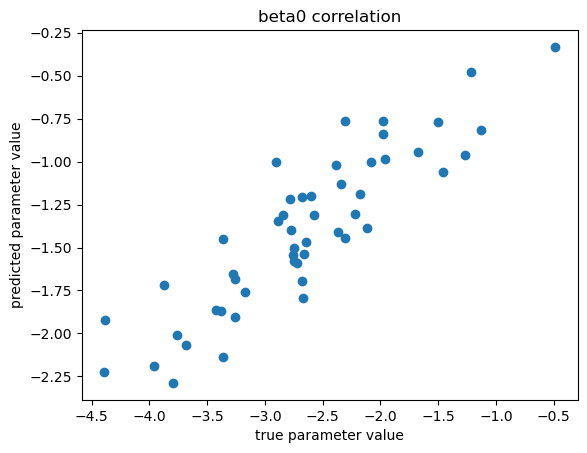

In [15]:
plt.scatter(beta0_k1g_norm.detach().numpy().flatten(), pred_beta0_k1g.detach().numpy().flatten())
plt.title('beta0 correlation')
plt.xlabel('true parameter value')
plt.ylabel('predicted parameter value')

### repeat for beta

In [16]:
## Get fit parameters
pred_beta_klg = pyro.get_param_store().get_param("beta").float().cpu()

In [22]:
print(pred_beta_klg)

tensor([[[-1.3344, -1.1312,  0.1713],
         [-1.7417,  0.1904, -0.5789]],

        [[-0.1037, -2.3995, -0.2469],
         [-1.4925, -0.4043, -0.0546]]], grad_fn=<ToCopyBackward0>)


In [23]:
print(beta_klg)

tensor([[[-1.0177, -1.3101,  0.5608],
         [-0.4122,  1.0828,  0.8087]],

        [[ 0.6186, -2.1781,  0.1132],
         [ 0.3671,  1.0375,  1.4806]]])


In [24]:
print(ncv_nl)

tensor([[0.3096, 0.6904],
        [0.0228, 0.9772],
        [0.1090, 0.8910],
        ...,
        [0.6807, 0.3193],
        [0.7192, 0.2808],
        [0.2850, 0.7150]], dtype=torch.float64)


tensor(-2.0882)


Text(0.5, 1.0, 'beta')

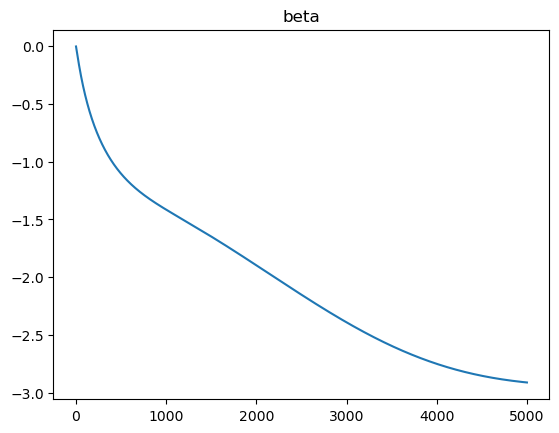

In [18]:
print(beta_klg[1, 0, 0])

beta_inspect = []
for beta_klg_temp in beta_klg_store:
    beta_inspect.append(beta_klg_temp[1, 0, 0].detach().numpy())
    
    
plt.plot(beta_inspect)
plt.title('beta')

In [17]:
## beta correlation
print("beta correlation:")
print(np.corrcoef(beta_klg.detach().numpy().flatten(), pred_beta_klg.detach().numpy().flatten())[0,1])

beta correlation:
0.7609252826388886


Text(0, 0.5, 'predicted parameter value')

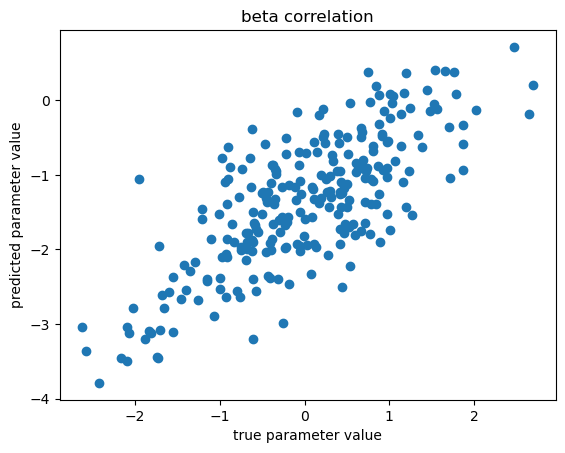

In [18]:
plt.scatter(beta_klg.detach().numpy().flatten(), pred_beta_klg.detach().numpy().flatten())
plt.title('beta correlation')
plt.xlabel('true parameter value')
plt.ylabel('predicted parameter value')

### compare model prediction to true values

Text(0, 0.5, 'predicted counts')

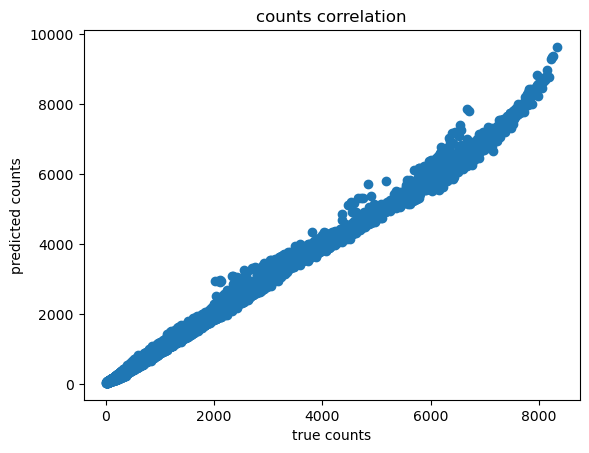

In [19]:
pred_counts_ng = gr.predict(train_dataset, 
                         num_samples = 10,
                         use_covariates = use_covariates_model)

plt.scatter(train_dataset.counts.flatten(), pred_counts_ng.detach().numpy().flatten())
plt.title('counts correlation')
plt.xlabel('true counts')
plt.ylabel('predicted counts')

In [20]:
print("counts correlation:")
print(np.corrcoef(train_dataset.counts.flatten(), pred_counts_ng.detach().numpy().flatten())[0,1])

counts correlation:
0.9981549424726057


Text(0, 0.5, 'predicted counts')

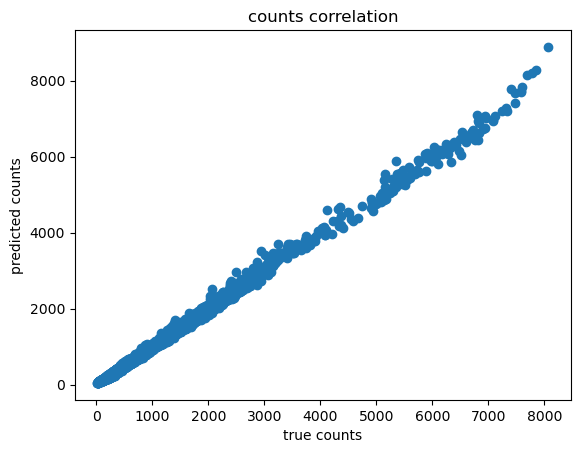

In [21]:
## predict on val dataset 

pred_val_counts_ng = gr.predict(val_dataset, 
                         num_samples = 10,
                         use_covariates = use_covariates_model)

plt.scatter(val_dataset.counts.flatten(), pred_val_counts_ng.detach().numpy().flatten())
plt.title('counts correlation')
plt.xlabel('true counts')
plt.ylabel('predicted counts')

In [22]:
print("counts correlation:")
print(np.corrcoef(val_dataset.counts.flatten(), pred_val_counts_ng.detach().numpy().flatten())[0,1])

counts correlation:
0.9985292295278224


In [29]:
torch.sum(ncv_nl1 * beta_nlg, dim=-2, keepdim=True)

tensor([[[-0.4514,  0.9250,  0.4898]],

        [[-0.1915,  0.8302, -0.9234]],

        [[-0.2643,  0.8567, -0.5276]],

        ...,

        [[-0.4701,  0.9319,  0.5917]],

        [[-1.9899, -0.5806, -0.0829]],

        [[-1.6486, -0.6549, -0.1947]]], dtype=torch.float64)

In [37]:
torch.sum(ncv_nl1 * pred_beta_klg[cell_ids_n], dim=-2, keepdim=True)

tensor([[[-0.9780, -0.3597, -0.7121, -1.3201, -1.4103]],

        [[-1.3996, -1.4427, -0.1323, -1.9952, -1.1642]],

        [[-0.7220, -0.6405, -1.8126, -0.4580, -1.4110]],

        ...,

        [[-1.3997, -1.4427, -0.1323, -1.9951, -1.1642]],

        [[-0.9779, -0.3598, -0.7121, -1.3200, -1.4103]],

        [[-0.9780, -0.3598, -0.7120, -1.3200, -1.4103]]], dtype=torch.float64,
       grad_fn=<SumBackward1>)

In [38]:
print(pred_counts_ng)

tensor([[ 430, 1436,  723,  218,  171],
        [ 177,  156, 2303,   56,  295],
        [ 718,  849,   78, 1219,  186],
        ...,
        [ 186,  161, 2281,   56,  291],
        [ 436, 1458,  722,  211,  183],
        [ 428, 1516,  754,  220,  179]])


In [39]:
print(counts_ng)

[[ 530. 1169.  877.  204.  171.]
 [ 223.   49. 2511.   49.  191.]
 [1097.  756.   59. 1028.   94.]
 ...
 [ 266.   91. 2346.   19.  247.]
 [ 784.  996.  977.  118.  153.]
 [ 316. 1912.  470.  211.  190.]]
